In [5]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from config import CONFIG, RL_CONFIG, SWING_CONFIG
from environment.grid import Grid
from environment.swing.solver import swing_solver
from environment.trajectory import is_stable

DTYPE = CONFIG.swing.dtype
# CONFIG.from_yaml("config.yaml")

In [6]:
def find_steady_state(
    grid: Grid, rng: np.random.Generator
) -> tuple[npt.NDArray[DTYPE], npt.NDArray[DTYPE]]:
    """Find random initial state of given grid.
    Args
        grid: In which grid to find initial state
        rng: used for initializing random phase
    Return
        phase: [S, N] phase of each node in (-pi, pi]
        dphase: [S, N] dphase (angular frequency) of each node
    """

    # Initial random state
    # phase = rng.uniform(-np.pi, np.pi, grid.num_nodes).astype(np.float32)
    phase = np.zeros(grid.num_nodes, dtype=DTYPE)
    dphase = np.zeros_like(phase, dtype=DTYPE)

    phases, dphases = [], []

    # Run swing equation until reaching steady time
    time = 0.0
    solver = swing_solver(grid.weighted_adjacency_matrix, grid.params)
    while time < RL_CONFIG.steady_time:
        time += SWING_CONFIG._dt
        phase, dphase = solver(phase=phase, dphase=dphase)
        phases.append(phase)
        dphases.append(dphase)
        if is_stable(dphase):
            break

    return np.stack(phases), np.stack(dphases)

grid = Grid(rng=0)


Node 0 - Type: CONSUMER, max: 10, active: 6
Node 1 - Type: GENERATOR, max: 11, active: 6
Node 2 - Type: GENERATOR, max: 6, active: 4
Node 3 - Type: CONSUMER, max: 10, active: 6
Node 4 - Type: GENERATOR, max: 10, active: 5
Node 5 - Type: RENEWABLE, max: 3, active: 1
Node 6 - Type: RENEWABLE, max: 6, active: 4
Node 7 - Type: GENERATOR, max: 6, active: 4
Node 8 - Type: CONSUMER, max: 10, active: 6
Node 9 - Type: SINK, max: 10, active: 6
Steady at t=17.267, max_dphase=9.813396025869567e-05


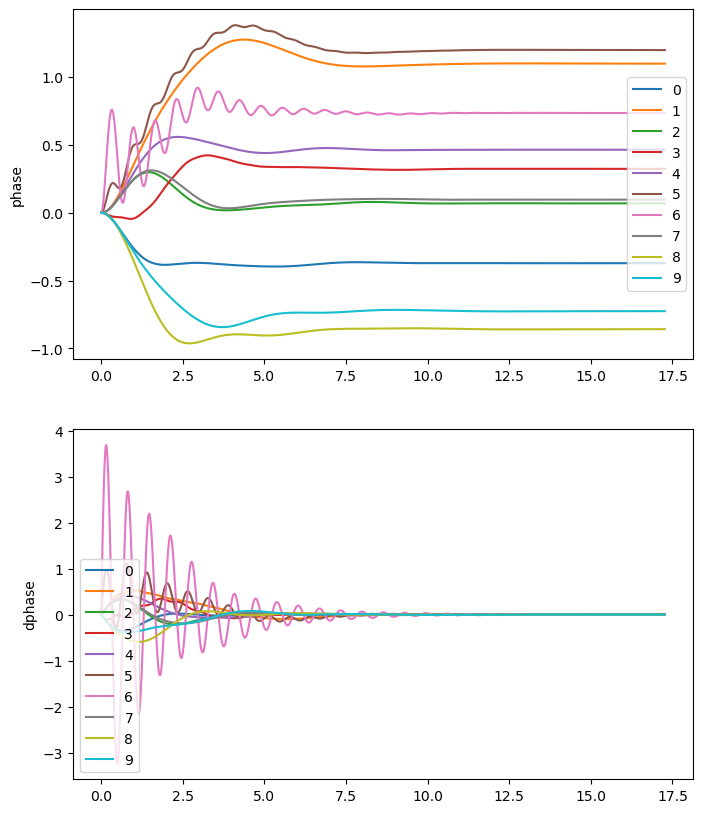

In [15]:
# grid.reset_nodes()
# grid.reset_node_types()
# grid.reset_graph()
# grid.reset_coupling()

print(grid)

phases, dphases = find_steady_state(grid, grid.rng)
time = np.arange(0.0, RL_CONFIG.steady_time, SWING_CONFIG._dt)
t = len(dphases) * SWING_CONFIG._dt
max_dphase = np.abs(dphases[-1]).max()
if t == RL_CONFIG.steady_time:
    print(f"Couldn't find steady state, {max_dphase=}")
else:
    print(f"Steady at {t=}, {max_dphase=}")

fig, axes = plt.subplots(nrows=2, figsize=(8, 10))

for i, (phase, dphase) in enumerate(zip(phases.T, dphases.T)):
    axes[0].plot(time[: len(phase)], phase, label=i)
    axes[1].plot(time[: len(dphase)], dphase, label=i)
axes[0].legend()
axes[0].set_ylabel("phase")
axes[1].legend()
axes[1].set_ylabel("dphase")
# plt.xlim(0, time[-1])
# plt.show()
fig.show()